In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('data/wheat_new.csv',decimal=',')

In [6]:
df

,Unnamed: 0,file,DAS,plot nº,photo nº,species,water_treatment,management,plot m2,avg_water (L m-2),...,P (kg microplot-1),K (kg microplot-1),avg_height,GA,GGA,CSI,NGRDIveg,TGIveg,final yield (kg),dataset
0,0,20220517_1 (1).JPG,96,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.959407,0.904393,5.734098,0.1324,2569.2709,9.15,train
1,1,20220517_1 (2).JPG,96,1,(2).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.963030,0.905523,5.971505,0.1316,2648.0105,9.15,train
2,2,20220517_1 (3).JPG,96,1,(3).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.953708,0.898722,5.765430,0.1331,2736.4337,9.15,train
3,3,20220517_1 (4).JPG,96,1,(4).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.957117,0.898772,6.095965,0.1267,2550.8238,9.15,train
4,4,20220602_1 (1).JPG,112,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.892348,0.791199,11.335180,0.1008,1880.2128,9.15,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,20220615_25 (4).JPG,125,25,(4).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.788544,0.323428,58.984136,0.0491,2277.6824,7.95,test
252,252,20220701_25 (1).JPG,141,25,(1).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.031868,0.009072,71.532905,0.0342,946.1760,7.95,test
253,253,20220701_25 (2).JPG,141,25,(2).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.025828,0.006849,73.483356,0.0314,867.4491,7.95,test
254,254,20220701_25 (3).JPG,141,25,(3).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.022065,0.004773,78.367629,0.0196,855.3556,7.95,test


In [ ]:
df['

In [5]:
dftrain = df[(df.dataset=='train')|(df.dataset=='validation')]
dftrain.loc[:,'dataset'] =  dftrain['dataset'].apply(lambda x: x=='validation')
df.loc[:,'dataset'] =  df['dataset'].apply(lambda x: x=='test')

In [6]:
db = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_x=[ColReader('file',pref='wheat_all/')],
                 get_y=[ColReader('final yield (kg)')],
                 splitter=ColSplitter(col='dataset'),    
                 item_tfms = Resize(640),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])
dls = db.dataloaders(dftrain,bs=8)

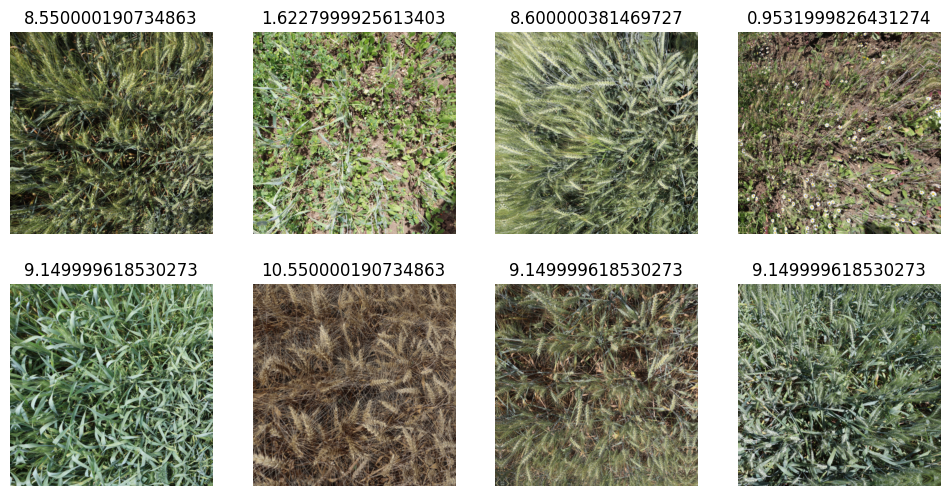

In [7]:
dls.show_batch()

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='convnext_yield')
]

In [9]:
from fastai.metrics import mae,rmse,mse

In [10]:
learn = Learner(dls, timm.create_model('convnext_base',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [11]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,34.801811,20.390635,3.297899,4.515599,20.390635,00:14


Better model found at epoch 0 with valid_loss value: 20.390634536743164.


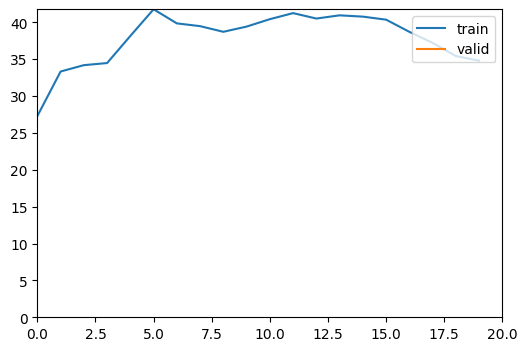

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,15.201339,15.299582,2.912745,3.911468,15.299582,00:13
1,12.600934,10.855476,2.510241,3.294765,10.855476,00:13
2,10.044895,7.604964,2.183045,2.757710,7.604964,00:13
3,7.827906,5.446169,1.960297,2.333703,5.446169,00:13
4,6.017653,4.123556,1.773510,2.030654,4.123556,00:13
5,4.623903,3.326358,1.639710,1.823831,3.326358,00:13
6,3.595145,2.782509,1.496560,1.668085,2.782509,00:13
7,2.813309,2.396577,1.469941,1.548088,2.396577,00:13
8,2.203532,2.281734,1.360441,1.510541,2.281734,00:13
9,1.733831,1.661899,1.240235,1.289146,1.661899,00:13


Better model found at epoch 0 with valid_loss value: 15.299581527709961.


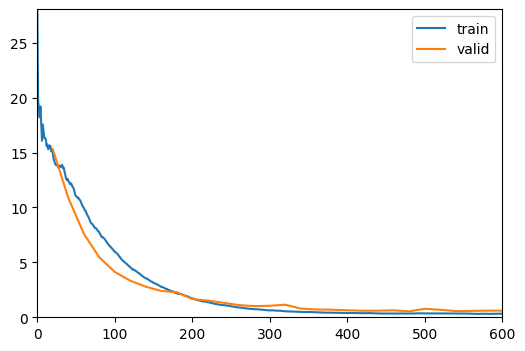

Better model found at epoch 1 with valid_loss value: 10.855476379394531.
Better model found at epoch 2 with valid_loss value: 7.604963779449463.
Better model found at epoch 3 with valid_loss value: 5.446168899536133.
Better model found at epoch 4 with valid_loss value: 4.123556137084961.
Better model found at epoch 5 with valid_loss value: 3.3263583183288574.
Better model found at epoch 6 with valid_loss value: 2.7825093269348145.
Better model found at epoch 7 with valid_loss value: 2.3965768814086914.
Better model found at epoch 8 with valid_loss value: 2.281733989715576.
Better model found at epoch 9 with valid_loss value: 1.6618986129760742.
Better model found at epoch 10 with valid_loss value: 1.5208003520965576.
Better model found at epoch 11 with valid_loss value: 1.32289457321167.
Better model found at epoch 12 with valid_loss value: 1.1073603630065918.
Better model found at epoch 13 with valid_loss value: 1.0166079998016357.
Better model found at epoch 16 with valid_loss value:

In [12]:
learn.fine_tune(30,base_lr=1e-4)

In [13]:
db = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_x=[ColReader('file',pref='wheat_all/')],
                 get_y=[ColReader('final yield (kg)')],
                 splitter=ColSplitter(col='dataset'),    
                 item_tfms = Resize(640),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])
dls = db.dataloaders(df,bs=8)

In [14]:
learn.dls=dls

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9990639090538025.


(#4) [1.6477665901184082,0.9990639090538025,1.2836536169052124,1.6477665901184082]